<a href="https://colab.research.google.com/github/avionerman/computational_and_statistical/blob/svhn_kpca_linear_svm_linear/novissimus_unified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project creator

**Creator**: [Dimitrios Papadopoulos](https://www.linkedin.com/in/jpapadopoulos/) 👾 <br>
**Email**: papadopoulos.v.dimitris@gmail.com <br>
**Academic email:** dpapadoac@csd.auth.gr<br>
**Date**: Dec 9th 2025 (Part A) | Dec 24th 2025 (Part B) <br>
**Project**: PCA+SVM (Part A) & KPCA+LDA (Part B)<br>
**Graphs repo**: https://shorturl.at/viMe7

*If you can't see the graphs, feel free to reach me out, and I'll grant you the needed access.*


# ❗ Simply click on Run all, and wait for the results

# Holistic Summary for all the Models in the project

## **Project description**

**Στοχος**:

Ηταν η κατανοηση της αποδοσης κλασικων αλγοριθμων μετα απο PCA και μελετη της αλληλεπιδρασης μεταξυ μειωσης διαστασεων, μη γραμμικοτητας και δομης των datasets.

<br>

**Βηματα/Pipeline:** <br>

Ολα τα πειραματα πραγματοποιηθηκαν με ενα ενιαιο pipeline προεπεξεργασιας και ταξινομησης, το οποιο περιλαμβανε:

*   Μετατροπη των εικονων σε διανυσματα χαρακτηριστικων (**flatten**).
*   Κανονικοποιηση των pixels στο ευρος [0, 1] (**normalization**).
*   Τυποποιηση με mean=0 και std=1 μονο πανω στα training δεδομενα (**standardization**).
*   Εφαρμογη **PCA** με διατηρηση του 90% της συνολικης διακυμανσης.
*   Εκπαιδευση πεντε μοντελων ταξινομησης:
    1.   **Linear SVM**
    2.   **RBF SVM**
    3.   **Polynomial SVM**
    4.   **KNN**
    5.   **Nearest Centroid (NCC)**
*   Χρηση GridSearchCV για **ευρεση βελτιστων υπερπαραμετρων**.
*   Αξιολογηση με **Accuracy**, **Precision**, **Recall**, **F1**, χρονο εκπαιδευσης και confusion matrices.

<br>

**Αποτελεσμα**:

Η συμπεριφορα των μοντελων καταδεικνυει τρεις βασικες τασεις:

- Το **PCA μειωνει δραστικα τη διασταση**, αλλα **δεν** **κανει** τις ταξεις **γραμμικα separable**.

- Το **RBF SVM** ειναι σταθερα το **καλυτερο μοντελο**, ανεξαρτητα απο το dataset.

- Ο αριθμος των **PCA components αντικατοπτριζει την πολυπλοκοτητα του dataset** (EuroSAT 152, COLON 114, CIFAR-10 103, SVHN 26).




# Import libraries/packages

In [1]:
#!pip install cupy-cuda12x
import os
import time
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp # np alternative for gpu

# scikit lib (cpu) for data loading and metrics only
from sklearn.model_selection import ParameterGrid, StratifiedKFold #datasplitting
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler #standarization with scaler
from scipy.io import loadmat
import seaborn as sns

# cuml alt of sklearn lib with gpu for models & pca
from cuml.svm import LinearSVC, SVC
from cuml.neighbors import KNeighborsClassifier
from cuml.decomposition import PCA as cuPCA
from cuml.model_selection import GridSearchCV
from sklearn.neighbors import NearestCentroid

# task B: kpca + lda imports (cpu only - no gpu support for kpca)
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# ⚠️ Configuration

In [14]:
DATASET_NAMES = ["SVHN"]  # "COLON", "EUROSAT", "SVHN"
RANDOM_STATE = 42
SHOW_EXAMPLES = True

RUN_PCA = False
RUN_KPCA_LDA = True

USE_PCA = False
PCA_VARIANCE = 0.90

KPCA_KERNELS = ["rbf", "poly"]
KPCA_N_COMPONENTS = 100

Δημιουργω τη μεταβλητη random state ωστε να χρησ/θει στο PCA - πολλες φορες ο διαχωρισμος train/test και η ιδια η εκπαιδευση των μοντελων περιεχουν στοχαστικα στοιχεια. Ετσι η μεταβλητη βοηθαει ωστε τα αποτελεσματα να μπορουννα γινουν reproduce και compare.

# Custom prep of EUROSAT & COLON HISTO

## Colorectal histology dataset prep

In [3]:
def load_colorectal_histology(resize_to=(48, 48)):
    """
    loading the colorectal_histology dataset from tensorflow dataset
    resize only this dataset to avoid gpu out-of-memory in pca
    """

    import tensorflow_datasets as tfds
    import numpy as np
    import cv2
    from sklearn.model_selection import train_test_split

    print("Loading colorectal_histology from TFDS ...")

    ds, info = tfds.load("colorectal_histology", split="train", with_info=True)

    class_names = info.features["label"].names  # 8 tissue classes

    X = []
    y = []

    for sample in tfds.as_numpy(ds):
        img = sample["image"].astype("float32")
        img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)

        X.append(img)
        y.append(sample["label"])

    X = np.array(X)
    y = np.array(y)

    print(f"Loaded COLON: {X.shape[0]} samples | resized to: {X.shape[1:]}")

    x_train, x_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )

    return (x_train, y_train), (x_test, y_test), class_names


Εκανα resize τις εικονες γιατι με 96x96 εσκαγε η εκτελεση του PCA. Επισης εκανα mapping τα labels με integers και στο τελος απλως αποθηκευσα τα training & test αντιστοιχα στα x και y.

## EUROSAT dataset prep

In [4]:
def load_eurosat():
    import tensorflow_datasets as tfds
    import numpy as np

    print("Loading EuroSAT...")

    ds_train = tfds.load("eurosat/rgb", split="train", shuffle_files=True)

    X = []
    y = []
    class_names = None

    for sample in tfds.as_numpy(ds_train):
        if class_names is None:
            class_names = sample["label"].__array_interface__["data"]
        X.append(sample["image"])
        y.append(sample["label"])

    X = np.array(X)
    y = np.array(y)

    # 80 / 20 train/test split
    split = int(0.6 * len(X))
    x_train, x_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # class names extract
    info = tfds.builder("eurosat/rgb").info
    class_names = info.features["label"].names

    return (x_train, y_train), (x_test, y_test), class_names


# Data loading

In [15]:
def load_data(dataset_name):
    """
    returns: (x_train, y_train), (x_test, y_test), class_names
    """

    print(f"Loading {dataset_name} ...")

    if dataset_name == "CIFAR10":
        from tensorflow.keras.datasets import cifar10
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()

        # flatten data from (n,1) to (n)
        y_train = y_train.flatten()
        y_test = y_test.flatten()

        class_names = [
            "airplane", "automobile", "bird", "cat", "deer",
            "dog", "frog", "horse", "ship", "truck"
        ]

    elif dataset_name == "SVHN":
        def get_svhn_split(split, data_dir="./data"):
            os.makedirs(data_dir, exist_ok=True)
            urls = {
                "train": "http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
                "test":  "http://ufldl.stanford.edu/housenumbers/test_32x32.mat",
            }

            # store the data (if doesn't exist) localy
            filepath = os.path.join(data_dir, urls[split].split("/")[-1])
            if not os.path.exists(filepath):
                print(f"Downloading SVHN {split} set...")
                urllib.request.urlretrieve(urls[split], filepath)

            # from matlab to python dict
            data = loadmat(filepath)
            X = np.transpose(data["X"], (3, 0, 1, 2)) # bringing N first from 4th to 1st idx
            y = data["y"].flatten() # flatten data from (n,1) to (n) - similar to cifar10
            y[y == 10] = 0 # digit 0 has wrong label, would not work right in the next steps
            return X, y

        x_train, y_train = get_svhn_split("train")
        x_test, y_test = get_svhn_split("test")
        class_names = [str(i) for i in range(10)]

    elif dataset_name == "EUROSAT":
      (x_train, y_train), (x_test, y_test), class_names = load_eurosat()

    elif dataset_name == "COLON":
      (x_train, y_train), (x_test, y_test), class_names = load_colorectal_histology()


    else:
        raise ValueError("Invalid DATASET_NAME. Choose 'CIFAR10', 'SVHN', or 'DOTA'.")

    print(f"Dataset Loaded. Train: {x_train.shape}, Test: {x_test.shape}")
    return (x_train, y_train), (x_test, y_test), class_names


Επελεξα τα Histology, EuroSAT, CIFAR-10 και SVHN για να διαφερουν ως προς τον αριθμο δειγματων, τον αριθμο κατηγοριων και τη διαστασιμοτητα. Αυτο μου επιτρεπει να μελετησω τη συμπεριφρα του PCA και των SVMs σε πραγματικα προβληματα υψηλων διαστασεων σε σχεση με πορβληματα μετριων διαστασεων. Κατα αυτον τον τροπο μπορω να δω τη συμβολη του PCA και το ποσο βοηθαει/αποδιδει, ειτε χρονικα ειτε απο καθαρο ζητημα κοστους υπολογισμου.

Οσον αφορα το EuroSAT και COLON datasets, κρατησα το χρωμα αντι να γινουν ασπρομαυρες οι φωτογραφιες (που πιθανον να ηταν πιο ευκολο για αναλυση, ειδικα με pca) γιατι αν χασω το χρωμα τοτε χανω τεραστιο μερος της πληροφοριας γιατι δε θα μπορει να γινουν διακριτες καποιες κομβικης σημασιας γωνιες και σημεια της φωτογραφιας καθως μιλαμε για ιστορολογιεσ φωτογραφιες ή δορυφορικες εικονες. Το χρωμα μπορει να αποτελει ισως και τον νο1 παραγοντα διακριτικοποιησης τους.

# Preprocessing

In [16]:
def preprocess_pipeline(x_train, x_test, use_pca=True, variance=0.90):
    # flatten and normalize in cpu mode
    print("Flattening data ...")
    print("Normalizing data ...")
    x_train_flat = x_train.reshape(len(x_train), -1).astype("float32") / 255.0
    x_test_flat  = x_test.reshape(len(x_test), -1).astype("float32") / 255.0

    # standardize in cpu mode
    print("Standardizing data ...")
    scaler = StandardScaler() # x_scaled = (x-xmean)/std | mean=0, std=1
    x_train_scaled = scaler.fit_transform(x_train_flat)
    # never fit the test data - data leakage - reuse mean & std from the training data to standarize them
    x_test_scaled  = scaler.transform(x_test_flat)

    # pca in gpu mode
    if use_pca:
        print(f"PCA enabled with variance: {variance} ...")
        # move scaled data to cp arrays (prepare for gpu)
        x_training_gpu = cp.asarray(x_train_scaled)
        x_testing_gpu = cp.asarray(x_test_scaled)

        # components is the max allowed number of components
        # (whichever is smaller | =features, or =samples)
        n_samples, n_features = x_training_gpu.shape
        n_components_full = min(n_samples, n_features)

        # with the components calculated above we run a full pca
        pca_full = cuPCA(n_components=n_components_full)
        pca_full.fit(x_training_gpu)

        # how much of the total variance does this component explain?
        # calculate exact components needed for variance threshold
        # example, if variance=0.90 and cumulative is [0.40, 0.62, 0.75, 0.83, 0.89, 0.92]

        explained_var = cp.cumsum(pca_full.explained_variance_ratio_)

        var_thresh = cp.array([variance])
        # then the first value is >= 90 (0.92) at index 5 (components 5+1)
        # so user gives 90%, and n_componenets tells us how many componenets we need (example: 6)
        n_components = int(cp.searchsorted(explained_var, var_thresh)[0]) + 1

        print(f"Components needed: {n_components}")

        # rerun with exact components (take from the previous pca execution)
        # info: this happened because the cuML pca needs componenets num. and not %
        pca_final = cuPCA(n_components=n_components)
        x_train_final = pca_final.fit_transform(x_training_gpu)
        x_test_final = pca_final.transform(x_testing_gpu)

        return x_train_final, x_test_final
    else:
        # execution without pca enabled
        print("PCA disabled. Moving raw standardized data to GPU...")
        return cp.asarray(x_train_scaled), cp.asarray(x_test_scaled)

## Flat-Norm-Stand analysis



1.    **Flattening**: To flattening μετατρεπει καθε εικονα από 3D πινακα (32x32x3) σε ενα μονοδιαστατο διανυσμα 3072 τιμων. Επισης θα ηθελα να προσθεσω πως δεν αλλαζει την πληροφορια, απλως αλλαζει την αναπαρασταση της.  Ομως ενα αρνητικο του flattennig ειναι οτι χανουμε την χωρικη πληροφορια της εικονας, που ομως δεν επηρεαζει τα SVMs.


2.   **Normalization**: Η κανονικοποιηση διαιρει τις τιμες pixel (0-255) δια 255 ωστε να βρισκονται στο διαστημα 0-1. Βελτιωνει την αριθμητικη σταθεροτητα και αποτρεπει τα μεγαλα pixel values από το να κυριαρχουν στις αποστασεις (χρησιμο για SVM & kNN). Κανει επισης την τυποποιηση (standardization) που ακολουθει πιο σταθερη μαθηματικα. Ειναι ενα απλο αλλα κρισιμο βημα προ-πεξεργασιας.

3.   **Standarization**: Το standardization αφαιρει τον μεσο όρο απο καθε χαρ/κο και το διαιρει με την τυπικη αποκλιση. Ετσι ολα τα features βρισκονται στην ιδια κλιμακα, κατι που ειναι απαραιτητο για SVM (margin-based) και PCA (variance-based). Αν δεν το κανω, χαρ/κα με υψηλη διακυμανση “καταπινουν”/εξαφανιζουν τα υπολοιπα. Το fit γινεται μονο στο training set για να αποφευχθει data leakage.






## PCA analysis

*    Ουσιαστικα με το pca θελω να μειωσω τις διαστασεις του δειγματος μου κρατοντας ομως αυτα τα features των οποιων η δυναμικη και η επεξηγιματικοτητα μπορει να κρατησει το 90% του δειγματος επεξηγησιμο.

*    Στον κωδικα μου, χρησ/ω 2 φορες τον PCA και ο λογος ειναι γιατι η βιβλιοθηκη cuML που χρειαζεται για να τρεξουμε κωδικα σε gpu mode, θελει πρωτα να βρουμε τα cumulative components του μοντελου κρατοντας το % (variance) σε καθε iteration. Μολις βρουμε το ποσοστο που θελουμε τοτε κραταμε το σημειο στο οποιο το βρηκαμε, και με βαση το σημειο ξερουμε ποσα components θελουμε. Αν για παραδειγμα το cumulative ειναι [0.40, 0.62, 0.75, 0.83, 0.89, 0.92], τοτε το 90% που θελουμε βρισκεται στο components = 6 (cumulative; 5+1). Τωρα, εφοσον ξερουμε το component (αρα ξερουμε ποσα components θελουμε για να φτασουμε 90%) μπορουμε να το χρησ/σουμε μαζι με το variance στην επομενη εκτελεση η οποια θα ειναι και η τελικη μας εκπαιδευση λαμβανοντας υποψη τα training & testing datasets (και τα 2 εχουν μετατραπει σε cp.arrays για να τρεξουν σε gpu mode).

*Για παραπανω λεπτομερειες χρησ/σα και σχολια μεσα στον κωδικα στα αγγλικα (μου ηταν πιο ευκολο).*

# Model Engines | SVM - NN - CNN

In [17]:
# 1
def run_model(model_type, x_train, y_train, x_test, y_test, classes, params=None):
    # imports needed localy since I run them standalone for testing
# 2
    import time
    import numpy as np
    import cupy as cp
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.neighbors import NearestCentroid
    from cuml.svm import LinearSVC, SVC
    from cuml.neighbors import KNeighborsClassifier
    from sklearn.model_selection import ParameterGrid, StratifiedKFold
# 3
    if params is None: params = {}
    print(f"\nRunning {model_type} ...")
    start_time = time.time()

# 4
    # data prep
    # i need cpu mode data so if the data are in gpu mode i transform them, if not ignore
    y_train_cpu = cp.asnumpy(y_train) if hasattr(y_train, 'device') else y_train
    y_test_cpu  = cp.asnumpy(y_test)  if hasattr(y_test, 'device') else y_test

# 5
    # i need gpu mode data so if the data are in cpu mode i transform them, if not ignore
    y_train_gpu = cp.asarray(y_train)
    x_train_gpu = cp.asarray(x_train) if not hasattr(x_train, 'device') else x_train
    x_test_gpu  = cp.asarray(x_test)  if not hasattr(x_test, 'device') else x_test

# 6
    # ncc model prep for cpu execution, NOT gpu (since it's not supported)
    if model_type == "NCC":
        base_clf = NearestCentroid()
        base_clf.fit(cp.asnumpy(x_train_gpu), y_train_cpu)
        best_model = base_clf
        best_params = "Default"
        # compute predictions
        predictions = best_model.predict(cp.asnumpy(x_test_gpu))
        y_train_pred = best_model.predict(cp.asnumpy(x_train_gpu))

# 7
    # define the models and their parameters (given, or if empty set the default i defined)
    else:
        if model_type == "LinearSVC":
            ModelClass = LinearSVC
            grid_params = params if params else {"C": [0.1, 1, 10]}
        elif model_type == "RBF_SVM":
            ModelClass = lambda **k: SVC(kernel="rbf", **k)
            grid_params = params if params else {"C": [1, 10], "gamma": ["scale"]}
        elif model_type == "Poly_SVM":
            ModelClass = lambda **k: SVC(kernel="poly", **k)
            grid_params = params if params else {"C": [1], "degree": [3]}
        elif model_type == "KNN":
            ModelClass = KNeighborsClassifier
            grid_params = params if params else {"n_neighbors": [5, 11]}
        else:
            raise ValueError(f"Unknown model: {model_type}")

# 8
        # robust grid search
        # ie, {"C": [1, 10], "gamma": ["scale"]} or {"C": 1, "gamma": "scale"}
        # for the 1st example, would produce param_keys = ["C"]
        # ignoring the string elements,
        # since should be in the hyperparameters of the model and NOT under the grid parameters (wrong)!
        param_keys = [k for k, v in grid_params.items() if isinstance(v, list)]

        # compute the best model and its params
        # ie, if {"C": 1, "gamma": "scale"} (hyperparameters)
        # then there is no need for grid search
        # so build the model without grid
        if not param_keys:
            best_model = ModelClass(**grid_params)
            best_model.fit(x_train_gpu, y_train_gpu)
            best_params = grid_params

# 9
        # exact opposite ie, {"C": [1, 10], "gamma": ["scale"]} -- multiple values
        # then grid is needed
        else:
            best_score = -1
            # creating a split with 3 folds and shuffled data with a set random state
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

            # creates list of combs - from {"C": [1, 10], "gamma": ["scale", "auto"]}
            # to {"C": 1, "gamma": "scale"}, {"C": 1, "gamma": "auto"}, etc
            param_grid = list(ParameterGrid(grid_params))

            print(f"Grid Search {len(param_grid)} configs...")

# 10
            # simply parsing each parameter from the param_grid list from prev step
            for p in param_grid:
                scores = []

                # loop of 3 folds (stratified - keeping stable ratio per class)
                # 1st: 1+2 validate 3, 2nd: 1+3 validate 2, 3rd: 2+3 validate 1
                for train_idx, val_idx in skf.split(y_train_cpu, y_train_cpu):

                    # build model with parameter p
                    clf = ModelClass(**p)

                    #traing using gpu
                    clf.fit(x_train_gpu[train_idx], y_train_gpu[train_idx])

                    # prediction on each fold
                    preds = clf.predict(x_train_gpu[val_idx])

                    # back to cpu mode
                    # compute acc for each fold and append it to scores
                    scores.append(accuracy_score(cp.asnumpy(y_train_gpu[val_idx]), cp.asnumpy(preds)))

                # pick best hyper combo (avg of folds' acc per p)
                if np.mean(scores) > best_score:
                    best_score = np.mean(scores)
                    best_params = p

# 11
            # execute best model with the best params
            best_model = ModelClass(**best_params)
            best_model.fit(x_train_gpu, y_train_gpu)

# 12
        # get best model values in gpu mode
        y_train_pred_gpu = best_model.predict(x_train_gpu)
        y_train_pred = cp.asnumpy(y_train_pred_gpu)

        # best model calc on gpu mode
        y_test_pred_gpu = best_model.predict(x_test_gpu)

        # move them back to cpu because metrics will need them (metrics run on cpu mode)
        predictions = cp.asnumpy(y_test_pred_gpu)

    elapsed = time.time() - start_time

# 13
    # how well model fits training data
    train_acc = accuracy_score(y_train_cpu, y_train_pred)

# 14
    # how well model generalizes
    test_acc  = accuracy_score(y_test_cpu, predictions)

# 18
    # from the samples i predicted, how many were correct
    precision = precision_score(y_test_cpu, predictions, average='macro', zero_division=0)

# 19
    # from the samples belong to a class, how many I found
    recall = recall_score(y_test_cpu, predictions, average='macro', zero_division=0)

# 20
    # combo of precision and recall (avg for all classes) - balance
    f1 = f1_score(y_test_cpu, predictions, average='macro', zero_division=0)

    # UPDATED PRINT STATEMENT: Shows all metrics immediately
    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f} | "
          f"Prec: {precision:.4f} | Rec: {recall:.4f} | F1: {f1:.4f} | "
          f"Time: {elapsed:.2f}s | Params: {best_params}")

    # confusion matrix for each model using
    # test labels, predictions, classes names and the model itself
    plot_confusion_matrix(y_test_cpu, predictions, classes, model_type)

    return {
        "model": model_type,
        "train_acc": train_acc,
        "test_acc": test_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "time": elapsed,
        "params": best_params,
        "predictions": predictions
    }

## Build and Running Models


---


Στη συγκεκριμενη εργασια επελεξα να εκτελεσω:

*  **LinearSVC** χρησ/ντας τη βιβλιοθηκη (LIBSVM - https://www.csie.ntu.edu.tw/~cjlin/libsvm/ υπο την ομπρελα της cuml για να τρεχει σε gpu mode). Για τη μεθοδολογια αυτη οριζω τα grid params ως εξης: `grid_params = params if params else {"C": [0.1, 1, 10]}`. Σε περιπτωση που ο χρηστης στη main δε περασει παραμετρους, αυτες οι default θα χρησ/θουν. Θεωρησα υπερβολικο να βαλω μεγαλους αριθμους C συν οτι απο ενα C και μετα χαλαει το αποτελεσμα και κραταει παραπανω χρονο. Το βελτιστο συνηθως βρισκοταν μεταξυ 1 και 10, και πιο συγκεκρινα το 5 πολλες φορες ηταν το βελτιστο, για αυτο και στη main θα δειτε πως το χρη/ω αρκετα (καθαρα απο try n error που εκανα εμπειρικα).

*  **SVC(kernel=rb)** χρησ/ντας τη βιβλιοθηκη (ειναι χτισμενη στον πυρηνα της cuml και επισης ειναι υπο την ομπρελα της cuml για να τρεχει σε gpu mode). Για τη μεθοδολογια αυτη οριζω τα grid params ως εξης: `grid_params = params if params else {"C": [1, 10], "gamma": ["scale"]}`. Σε περιπτωση που ο χρηστης στη main δε περασει παραμετρους, αυτες οι default θα χρησ/θουν. Οπως και στο παραπανω παραδειγμα, θεωρησα υπερβολικο να βαλω C παραπανω απο 10 και επειδη παιρνει παραπανω χρονο σαν μεθοδολογια, μειωσα και το συνολο των C κατα 1 (του 0.1 που δεν συνεβαλε και ιδιαιτερα). Το gamma το ορισα ως scale και οχι auto γιατι προσαρμοζει το γαμα (γ) στη διασπορα των δεδομενων, κατι που βοηθα στη δημιουργια ενος πιο ισορροπημενου boundary αποφασης (**με auto υπαρχει κινδυνος για overfit**).

*  **SVC(kernel=poly)** χρησ/ντας τη βιβλιοθηκη (ειναι χτισμενη στον πυρηνα της cuml και επισης ειναι υπο την ομπρελα της cuml για να τρεχει σε gpu mode). Για τη μεθοδολογια αυτη οριζω τα grid params ως εξης: `grid_params = params if params else {"C": [1], "degree": [3]}`. Σε περιπτωση που ο χρηστης στη main δε περασει παραμετρους, αυτες οι default θα χρησ/θουν. Οπως και στο παραπανω παραδειγμα, θεωρησα υπερβολικο να βαλω C παραπανω απο 1 και επειδη παιρνει παραπανω χρονο σαν μεθοδολογια ακομα και απο την rbf, μειωσα και το συνολο των C κατα 2 (του 0.1 και 10 που δεν συνεβαλαν και ιδιαιτερα). Το degree το ορισα ως 3 (εκανα πολλες δοκιμες και με το 2, αλλα το 3 εβγαζει πιο βελτιστο αποτελεσματα). Πρακτικα το degree ειναι ο εκθετης του πολυωνυμου — καθοριζει τον βαθμο του πολυωνυμικου μετασχηματισμου στον χωρο χαρ/κων μου. **Αν αυξησω πολυ τον βαθμο** θα γινει πολυ καμπυλωτο το αποτελεσμα, και **το οριο θα ειναι** κ αυτο αρκετα **καμπυλο**. **Αυτο θα χαλασει το μοντελο κανοντας το πιο πολυπλοκο**. Για αυτο οι τιμες ειναι παντα μεταξυ 2 - 3 - 4. Παραπανω θεωρειται υπερβολικο εκτος αν υπαρχει καποιο edge case.

*  **NN(k)** χρησ/ντας τη βιβλιοθηκη KNeighborsClassifier (ειναι χτισμενη στον πυρηνα της cuml και επισης ειναι υπο την ομπρελα της cuml για να τρεχει σε gpu mode). Για τη μεθοδολογια αυτη οριζω τα grid params ως εξης: `grid_params = params if params else {"n_neighbors": [5, 11]}`. Σε περιπτωση που ο χρηστης στη main δε περασει παραμετρους, αυτες οι default θα χρησ/θουν. Ουσιαστικα ο αλγοριθμος τον κοντινοτερο γειτονα στο training set και παιρνει label του. Επισης δεν εχει νοημα για μεγαλο k γιατι οσο πιο μεγαλο τοσο πιο μεγαλη γειτοινια λαμβανει υποψη και χαλαει το αποτελεσμα. Εβαλα ως default το 5 και το 11, γιατι δειγματοληπτικα απο 1 μεχρι και 13 μου εβγαζε τα καλυτερα αποτελεσματα στα πειραματα που εκανα. Το περιεργο με τον αλγοριθμο ειναι οτι δεν μαθαινει, αλλα υπολογιζει δυναμικα τις αποστασεις. Παρολα αυτα πλλες φορες βγαζει πιο βελτισα αποτελεσματα ακομα και απο το SVC με τεραστια αναλογια υπερ του σε χρονο και κοστος (μονο η προβλεψη παιρνει καποιον χρονο παραπανω, αλλα με gpu mode ειναι παλι μικρος αυτος ο χρονος και για τα k που επιλεγω). **Αξιζει να σημειωθει ομως οτι NN ειναι ευαισθητος στον θορυβο και εχει θεμα σε υψηλες διαστασεις λογω του curse of dimensionality (lazy agl)**.

*  **NCC()** χρησ/ντας τη βιβλιοθηκη NearestCentroid (ειναι χτισμενη στον πυρηνα της sklearn και επισης ειναι υπο την ομπρελα της sklearn για να τρεχει σε cpu mode, καθως δεν υποστηριζεται σε gpu αοπ την cuml τουλαχιστον). Πρακτικα για καθε κλαση, υπολογιζει το κεντροειδες της (μεσος ορος ολων των δειγματων της κλασης c). Μετα, για ενα νεο δειγμα, υπολογιζει την αποσταση του δειγματος απο καθε κεντροειδες, και ετσι το δειγμα ταξινομειται στην κλαση του πιο κοντινου κεντροειδους. **Δουλευει καλα οταν οι κλασεις εχουν περιπου σφαιρικη ή ομοιομορφη κατανομη**. Βεβαια στο δικο μου παραδειγμα, χανω την σφαιρικοτητα αυτων, αφου απο 3D dataset (32x32x3) μετα απο flat-norm-stand καταληγω στη μορφη (3072, ) και ετσι η λπηροφορια που θελει ο NCC δεν υπαρχει.  Δε σημαινει πως δε θα τρεξει, απλως θα ειναι κατα πολυ χειροτερη η αποδοση του αποτελεσματος του. **Σε αντιθεση με τον kNN (NN) δεν ειναι ευαισθητος στον θορυβο**.




## Model's building & running code analysis



1. οριζω τη συναρτηση που δεχεται το τυπο του μοντελου, τα δεδομενα προς χρηση απο αυτο, τα labels, τα ονοματα των κλασεων και τελος τις παραμετρους που περναει ο χρηστης (αν θελει να στειλει, αλλιως εχω τις default που ανελυσα παραπανω).

2. οι βιβλιοθηκες και τα πακετα που κανω import - σημαντικο ειναι οτι χωρις τον cuml δε θα μπορουσα να τα τρεξω σε gpu.

3. αν δε λαβω params τοτε τρεχω το default

4. ουσιαστικα περναω τα gpu δεδομενα σε cpu για να χρησ/θουν παρακατω

5. κανω το αντιστροφο απο το βημα #4

6. χρησ/ω τον NCC με cpu mode και υπολογιζω τα predictions

7. αναλογως το τι περναει ο χρηστης σαν μοντελο (παραμετρο στη συναρτηση), τοτε κατασκευαζω και την αντιστοιχη μεθοδολογια και περναω τα default δεδομενα (παραμετρους) σε περιπτωση που δε λαβω κατι απο τον χρηστη, ή χρησ/ω τα params που περναει ο χρηστης (αυτο για καθε μοντελο). Τα defaults επιλεχθηκαν για να κρατησω μια γενικη εκτελεση ανα μοντελο και οχι καποια εξειδ/μενη καθως θα πρεπει να εισαι σε θεση να βγαλει κατι οσο πιο αποτελεσματικο αλλα και σε λογικο χρονο ανεξαρτητα της ιδιαιτεροτητας του καθε dataset.

8. απλως φτιαχνω τα parameters απο τη λιστα που ελαβα (σε περιπτωση που δε θελω τα default). Επισης στο σημειο αυτο αν ΔΕΝ εχω παραμετρους, υπολογιζω το καλυτερο μοντελο (με βαση το μοντελο που επιλεχθηκε) και κραταω τις καλυτερες παραμετρους του.

9. αλλιως, αν εχουν δωθει παραμετροι, τοτε τις λαμβανω, κανω 3 folds (cross-validation) περναω τα δεδομενα απο stratification (για να κρατησω οσο πιο balanced δειγμα γινεται) και φτιαχνω τη τελικη λιστα με τα δεδομενα ετοιμα προς 'καταναλωση' απο το μοντελο παρκατω.

10. για το καθε set παραμετρων, τρεχω μια εκπαιδεσυη του μοντελου, το εκπαιδευω, υπολογιζω τα predictions, και στο τελος κραταω το score του (cpu mode). Μετα, ψαχνω να βρω το καλυτερο score. Ετσι βλεπω ποιο set παραμετρων ηταν το καλυτερο. Μολις το βρω, κραταω το score και τις παραμετρους ως τα καλυτερα.

11. ξανατρεχω το μοντελο αυτη τη φορα με τις καλυτερες παραμετρους και περιμενω να εκπαιδευτει

12. μετα την εκπαιδευση υπολογιζω τα predictions με gpu mode, κραταω το καλυτερο prediction και μετα τα γυριζω παλι σε cpu mode για να υπολογιστουν οι μετρικες

13. με βαση τα predictions, υπολογιζω το training accuracy (ποσο καλα ταιριαζει το μοντελο στα training labels)

14. με βαση τα predictions, υπολογιζω το testing accuracy (ποσο καλα γενικευει το μοντελο στo test set)

15. με βαση τα predictions, υπολογιζω το precision (αν καποια κλαση δεν εχει δεδομενα για να μη σκασει βαζω το zero_devision=0). Ουσιαστικα με το precision βλεπουμε απο οσες περιπτωσεις εχει το μοντελο, ποσες προβλεψε οτι ανηκουν σε μια κλαση, και ποσες πραγματικα ηταν σωστες [TP/TP+FP]. Αν εχουμε μεγαλο precision σημαινει πως εχουμε λιγα FP (λαθος χαρακτιρισμενα ως θετικα στοιχεια).

16. με βαση τα predictions, υπολογιζω το recall. Πρακτικα, ειναι η ευαισθησια του μοντελου γιατι βλεπω απο τις περιπτωσεις που ανηκουν πραγματικα σε μια κλαση, ποσες επιασε σωστα το μοτενλο [TP/TP+FN]. Αν εχουμε υψηλο recall τοτε εχουμε λιγα χαμενα δειγματα. Ειναι πολυ πολυ σημαντικο αν δεν θελω να χασω καποια σημαντικη πληροφορια (αναλογως τα προβληματα μπορει να αποτελει και το πιο σημαντικο δεικτη, πχ αν θελω να δω απατες, ή θεματα υγειας με τα οποια θελω να μειωσω τετοια ρισκη).

17. με βαση τα predictions, υπολογιζω το f1 (για καθε κλαση κραταω τον συνδυασμο του precision & recall - αυτο ειναι ουσιαστικα το f1, το balance των δυο μεταβλητων - και εμτα βγαζω τον μεσο ορο για την καθε κλαση για να βγαλω τελικο αποτελεσμα). Εδω εχουμε οτι το F1 ειναι ενας ισορροποηενςο δεικτης μεταξυ precision & recall, επειδη θα τιμωρησει πολυ μεγαλες διαφορες αναμεσα στις δυο μετρικες. Οταν εχω ανισορροπια κλασεων (και recall με precision θα ιεναι πιθανως εκ διαμετρου αντιθετα) τοτε το F1 μπορει να μου δωσει ενα balanced αποτελεσμα [2 *((P*R)/P+R)].

*macro: οταν εχω προβλημα με ταξινομηση πολλων κλασεων, τοτε για καθε metric υπολογιζω ξεχωριστα την καθε κλαση, και μετα παιρνω τον ΜΟ για την καθε κλαση. Ετσι δε λαμβανω υποψη το ποσ δειγματα εχει η καθε κλαση, κρατοντας μια ισορροπια μεταξυ των κλασεων με βαση τον ΜΟ τους και οτι το πληθος των δειγματων τους. Αν ειχα κλασεις A, B, C τοτε αυτο που κανει το macro ειναι:
= [(f1(A) + f1(B) + f1(C)) / 3]. Το ιδιο ισχυει για ολες τις μετρικες (precision, recall, f1). *italicized text*





# 📊 Visualize True vs Pred results for an image sample

In [18]:
def visualize(x_raw, y_true, y_pred, classes, title):
    """
    Helps me to visulize the actual correct/incorrect images vs predictions.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    correct_idxs = np.where(y_true == y_pred)[0]
    incorrect_idxs = np.where(y_true != y_pred)[0]

    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{title} - Sample predictions", fontweight='bold', fontsize=14)

    # plot with max 5 successful results (green & correct for the successful)
    for i in range(min(5, len(correct_idxs))):
        idx = correct_idxs[i]

        img = x_raw[idx]
        img = np.clip(img, 0, 255).astype(np.uint8)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if i == 0: plt.title("CORRECT", color='green', fontweight='bold')

    # plot with max 5 failed results (red & incorrect for the failed)
    for i in range(min(5, len(incorrect_idxs))):
        idx = incorrect_idxs[i]

        img = x_raw[idx]
        img = np.clip(img, 0, 255).astype(np.uint8)

        plt.subplot(2, 5, i + 6)
        plt.imshow(img)
        plt.axis('off')

        # showing the labels from the dataset vs the labels from the preds
        true_label = classes[y_true[idx]]
        pred_label = classes[y_pred[idx]]
        plt.text(0, 38, f"T: {true_label}\nP: {pred_label}", fontsize=9, color='red')

        if i == 0: plt.title("INCORRECT", color='red', fontweight='bold')

    plt.tight_layout()
    plt.show()


## Successful/Failed Image Visualization analysis
---
Για την αξιολογηση των μοντελων ταξινομησης υλοποιηθηκε μια συναρτηση οπτικοποιησης, η οποια παρουσιαζει ενδεικτικα σωστες και λανθασμενες προβλεψεις. Η συναρτηση εντοπιζει ποια δειγματα ταξινομηθηκαν σωστα και ποια λαθος, και εμφανιζει εως πεντε εικονες απο καθε κατηγορια. Οι σωστες προβλεψεις εμφανιζονται στην πανω σειρα με πρασινο χρωμα, ενω οι λανθασμενες στην κατω σειρα με κοκκινο, μαζι με την πραγματικη και την προβλεπομενη ετικετα τους. Με αυτο τον τροπο εχουμε μια γρηγορη και κατανοητη εικονα της αποδοσης του μοντελου, επιτρεποντας τον εντοπισμο μοτιβων στα λαθη η πιθανων προβληματικων δειγματων

# 📊 True vs Pred results meet Confusion Matrix

In [19]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    """

    Small summary: shows us how many times the model had right or not right preds,
    while showing which classes confuses each other too.

    Helps me to visulize the confusion matrix for each model execution.
    The confusion matrix is a table that shows how my classifier performed by
    simply comparing the true labels and the pred labels
    The stronger the diagonical result (darker color) the better the prediction
    If it's not represented in the diagonical then it's an error
    That way I can also detect the confusions (ie, ship is getting confused with trick)

    """

    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # getting as input the true labels from the test set
    # and the labels predicted from the model
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)

    plt.title(f"{title} - Confusion Matrix", fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Confusion Matrix analysis


---


Για την αναλυση της αποδοσης των μοντελων ταξινομησης χρησιμοποιηθηκε μια συναρτηση που εμφανιζει το confusion matrix. Παρουσιαζει ποσες φορες το μοντελο προβλεπει σωστα ή λαθος συγκρινοντας τις πραγματικες ετικετες με τις προβλεπομενες. Οι τιμες στη διαγωνιο αντιστοιχουν σε σωστες προβλεψεις, ενω οι τιμες εκτος διαγωνιου δειχνουν τα λαθη και τις συγχυσεις μεταξυ των κλασεων. Μεσω αυτης της οπτικοποιησης μπορουμε να εντοπισουμε σε ποιες κλασεις το μοντελο αποδιδει καλα και σε ποιες υπαρχουν συστηματικα λαθη, διευκολυνοντας την αξιολογηση και τη βελτιωση του μοντελου.

# 📊 Visualize best models per dataset (graph)

In [20]:
def plot_model_comparison(results_df):
    """

    Line chart comparing all models across all metrics.

    """
    import matplotlib.pyplot as plt

    # metrics definition
    metrics = ['test_acc', 'precision', 'recall', 'f1_score']

    plt.figure(figsize=(12, 6))

    # create line for each model
    for i, row in results_df.iterrows():
        # values of each metric for each row
        y_values = row[metrics].values

        # the line itself accepting the metric, values, and the model
        plt.plot(metrics, y_values, marker='o', linewidth=2, label=row['model'])

        # adding numerical labels for visibility (min-max from 0 to 1)
        for x, y in zip(metrics, y_values):
            plt.text(x, y + 0.01, f"{y:.2f}", fontsize=8, ha='center')

    plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
    plt.ylabel('Score (0-1)', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Models")
    plt.tight_layout()
    plt.show()

## Linear Graph Visualization analysis

---


Στο πλαισιο της αξιολογησης των μοντελων δημιουργηθηκε μια συναρτηση visualization η οποια παρουσιαζει, με τη μορφη γραφηματος γραμμων, τις επιδοσεις καθε μοντελου ως προς τις κυριοτερες μετρικες αξιολογησης (accuracy, precision, recall, f1 score). Η συγκεκριμενη απεικονιση επιτρεπει την αμεση συγκριση της συμπεριφορας των μοντελων σε πολλαπλα κριτηρια, καθιστωντας ευδιακριτες τις διαφορες στην αποδοση τους. Μεσα απο αυτο διευκολυνεται η επιλογη του πιο βελτιστου μοντελου, αναλογα με τις απαιτησεις και τις προτεραιοτητες του καθε dataset ή των απαιτησεων του ζητηματος.

# ⚡ Main execution body

# KPCA+LDA Preprocessing (Task B)


## KPCA+LDA Analysis

Η μεθοδος **KPCA+LDA** (Kernel PCA + Linear Discriminant Analysis) συνδυαζει:

*   **Kernel PCA**: Μη γραμμικη εκδοχη του PCA με kernel functions (RBF, polynomial, κλπ)
*   **LDA**: Βρισκει διευθυνσεις που μεγιστοποιουν τον διαχωρισμο κλασεων

**Pipeline:** Flatten → Normalize → Standardize → KPCA → LDA → Classifiers (SVM, KNN, NCC)

**Σημαντικο:** Το KPCA τρεχει σε CPU (δεν υπαρχει GPU implementation στο cuML).


In [21]:
def preprocess_for_kpca(x_train, x_test):
    """
    Preprocessing for KPCA: flatten/normalize/standardize only (no PCA)
    """
    # flatten and normalize in cpu mode
    print("Flattening data ...")
    print("Normalizing data ...")
    x_train_flat = x_train.reshape(len(x_train), -1).astype("float32") / 255.0
    x_test_flat  = x_test.reshape(len(x_test), -1).astype("float32") / 255.0

    # standardize in cpu mode
    print("Standardizing data ...")
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_flat)
    x_test_scaled  = scaler.transform(x_test_flat)

    return x_train_scaled, x_test_scaled


In [22]:
def apply_kpca(x_train_scaled, x_test_scaled, kernel, n_components, gamma=None):
    """
    Apply Kernel PCA with specified kernel
    """
    # set gamma for rbf/poly/sigmoid kernels
    if gamma is None:
        gamma = 1.0 / x_train_scaled.shape[1]  # default: 1/n_features

    print(f"Applying Kernel PCA (kernel={kernel}, n_components={n_components}) ...")
    kpca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, random_state=42)
    x_train_kpca = kpca.fit_transform(x_train_scaled)
    x_test_kpca  = kpca.transform(x_test_scaled)

    print(f"KPCA output shape: {x_train_kpca.shape}")

    return x_train_kpca, x_test_kpca, kpca


In [23]:
def apply_lda(x_train_kpca, x_test_kpca, y_train):
    """
    Apply LDA on KPCA features
    """
    # lda max components = min(n_classes - 1, n_features)
    n_classes = len(np.unique(y_train))
    n_components = min(n_classes - 1, x_train_kpca.shape[1])

    print(f"Applying LDA (n_components={n_components}) ...")
    lda = LDA(n_components=n_components)
    x_train_lda = lda.fit_transform(x_train_kpca, y_train)
    x_test_lda  = lda.transform(x_test_kpca)

    print(f"LDA output shape: {x_train_lda.shape}")

    return x_train_lda, x_test_lda, lda


# 🚀 Main Execution (KPCA+LDA - Task B)


In [24]:
def compare_pca_vs_kpca_lda(pca_results, kpca_results):
    """
    Compare PCA (Task A) vs KPCA+LDA (Task B) results
    """
    print("\n" + "="*80)
    print("PCA vs KPCA+LDA COMPARISON")
    print("="*80)

    # combine results
    pca_df = pd.DataFrame(pca_results)
    pca_df["method"] = "PCA"

    kpca_df = pd.DataFrame(kpca_results)
    kpca_df["method"] = "KPCA+LDA"

    combined = pd.concat([pca_df, kpca_df], ignore_index=True)

    # summary by method and model
    summary = combined.groupby(["method", "model"]).agg({
        "test_acc": "mean",
        "f1_score": "mean",
        "time": "mean"
    }).round(4)

    print("\nAverage performance by method and model:")
    print(summary)

    return combined


Loading SVHN ...
Dataset Loaded. Train: (73257, 32, 32, 3), Test: (26032, 32, 32, 3)
Flattening data ...
Normalizing data ...
Standardizing data ...

RUNNING DATASET: SVHN | METHOD: KPCA(rbf)+LDA
Applying Kernel PCA (kernel=rbf, n_components=100) ...
KPCA output shape: (73257, 100)
Applying LDA (n_components=9) ...
LDA output shape: (73257, 9)

Running LinearSVC ...
Grid Search 2 configs...
Train Acc: 0.3756 | Test Acc: 0.3946 | Prec: 0.3971 | Rec: 0.3195 | F1: 0.3183 | Time: 0.22s | Params: {'C': 0.1, 'max_iter': 10000}


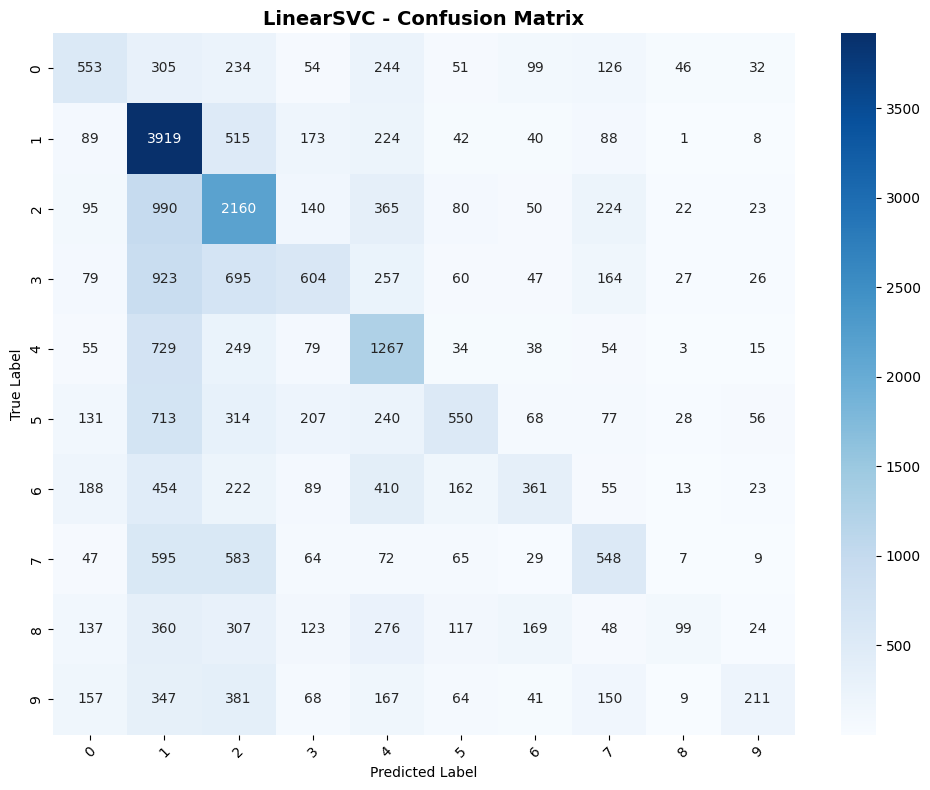

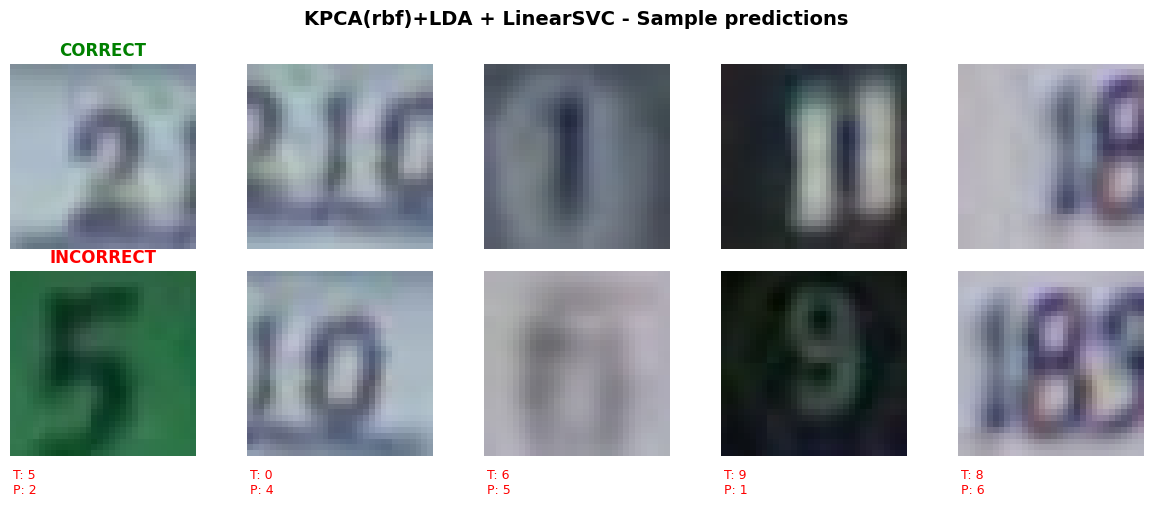


Running RBF_SVM ...
Grid Search 2 configs...
Train Acc: 0.4846 | Test Acc: 0.4738 | Prec: 0.4624 | Rec: 0.4177 | F1: 0.4283 | Time: 39.72s | Params: {'C': 1, 'gamma': 'scale'}


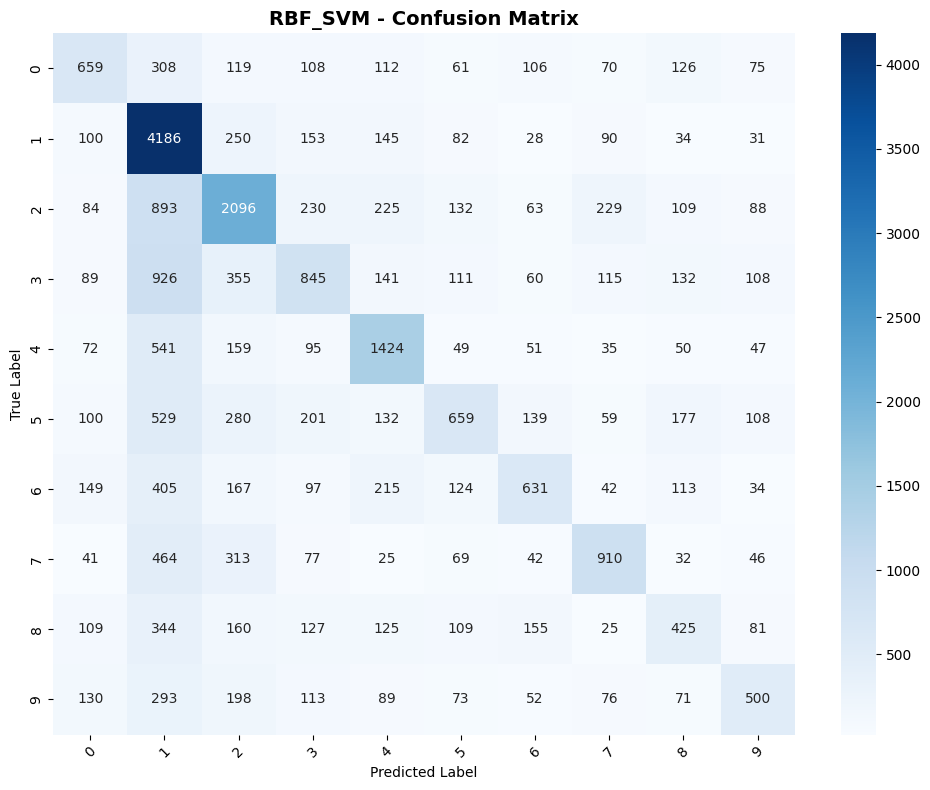

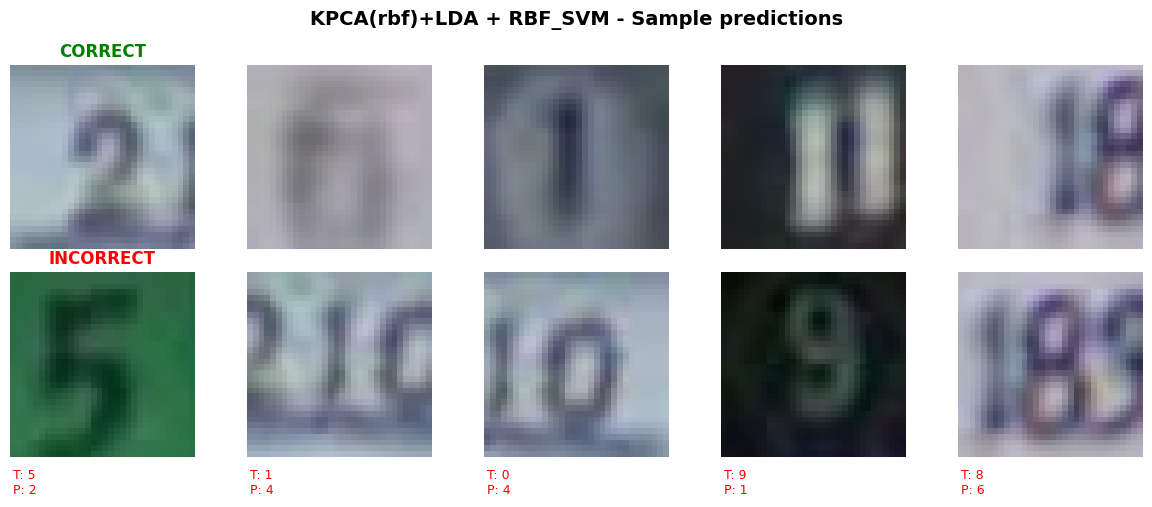


Running Poly_SVM ...
Grid Search 1 configs...
Train Acc: 0.4128 | Test Acc: 0.4133 | Prec: 0.4971 | Rec: 0.3411 | F1: 0.3696 | Time: 30.87s | Params: {'C': 1, 'degree': 3}


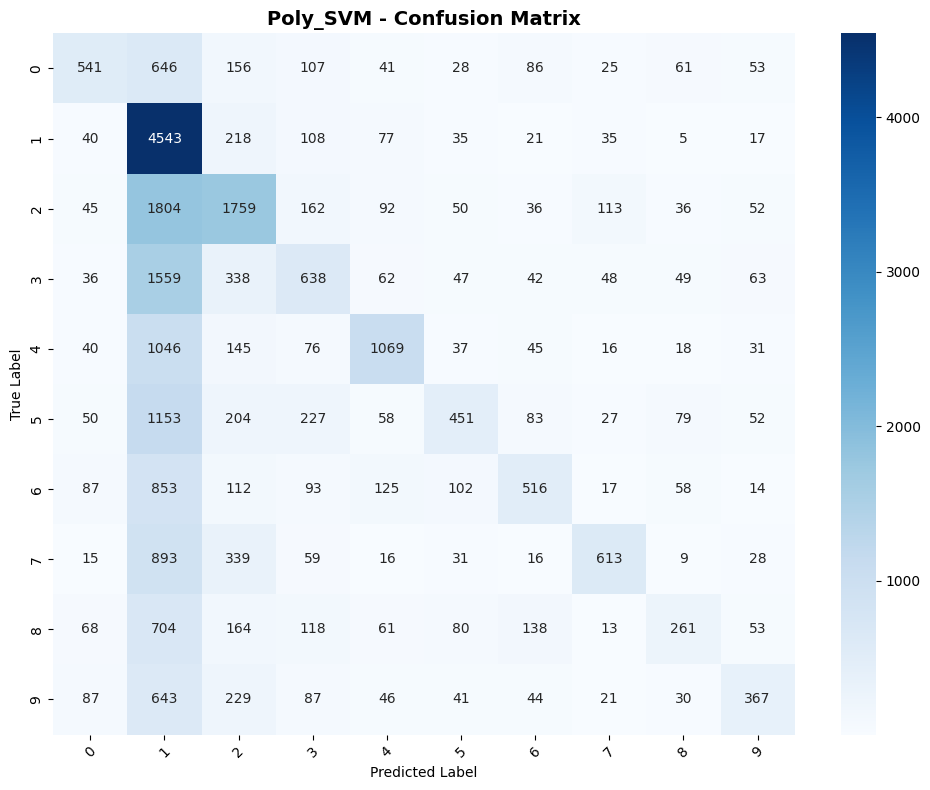


Running KNN ...
Grid Search 2 configs...
Train Acc: 0.5304 | Test Acc: 0.4332 | Prec: 0.4073 | Rec: 0.3796 | F1: 0.3837 | Time: 0.21s | Params: {'n_neighbors': 10}


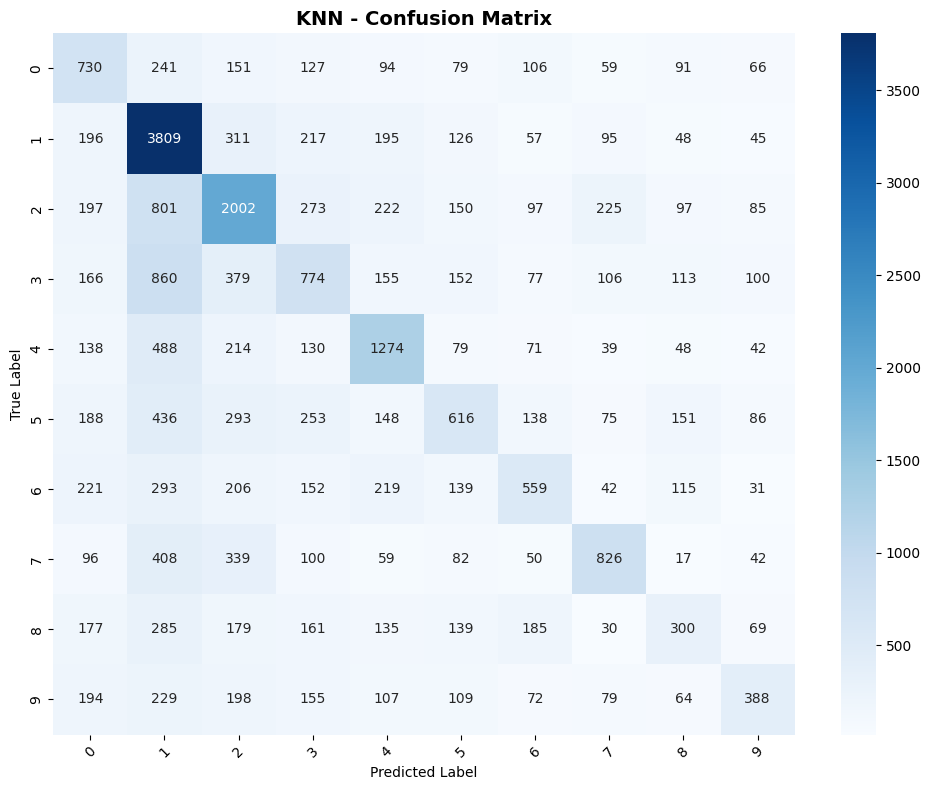


Running NCC ...
Train Acc: 0.3892 | Test Acc: 0.4011 | Prec: 0.3793 | Rec: 0.3886 | F1: 0.3741 | Time: 0.07s | Params: Default


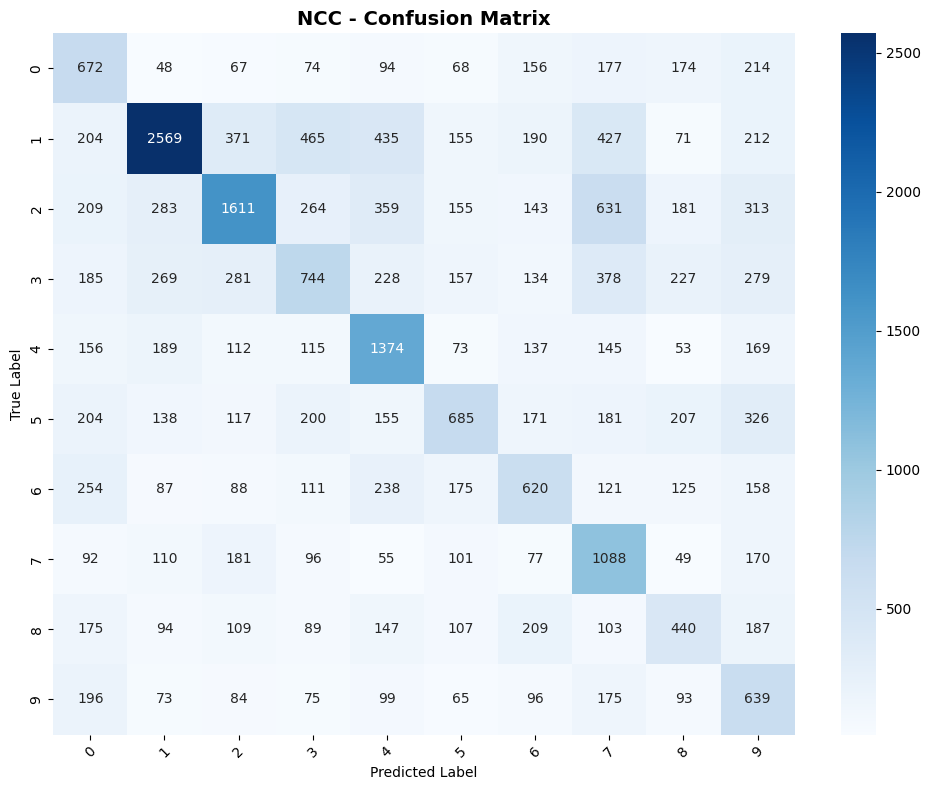


FINAL METRICS SUMMARY (SVHN | KPCA(rbf)+LDA)
    model  train_acc  test_acc  f1_score  precision  recall    time                        params
LinearSVC     0.3756    0.3946    0.3183     0.3971  0.3195  0.2174 {'C': 0.1, 'max_iter': 10000}
  RBF_SVM     0.4846    0.4738    0.4283     0.4624  0.4177 39.7230    {'C': 1, 'gamma': 'scale'}
 Poly_SVM     0.4128    0.4133    0.3696     0.4971  0.3411 30.8674         {'C': 1, 'degree': 3}
      KNN     0.5304    0.4332    0.3837     0.4073  0.3796  0.2054           {'n_neighbors': 10}
      NCC     0.3892    0.4011    0.3741     0.3793  0.3886  0.0702                       Default

Generating Model Comparison Chart...


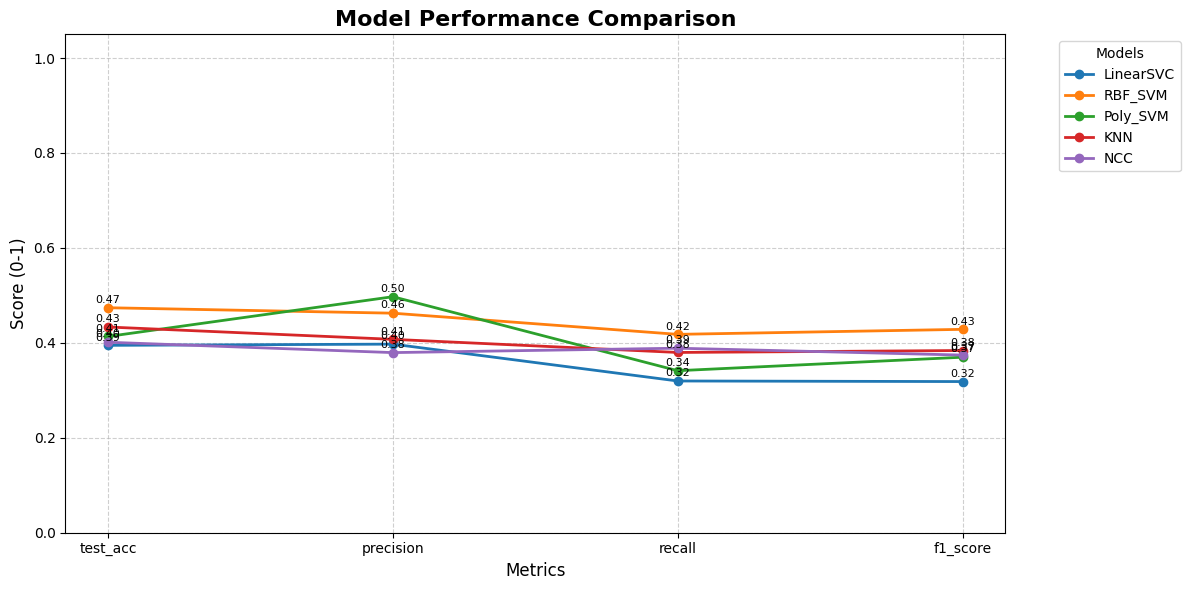


RUNNING DATASET: SVHN | METHOD: KPCA(poly)+LDA
Applying Kernel PCA (kernel=poly, n_components=100) ...


In [ ]:
def main():

    # models to run (same for both PCA and KPCA+LDA)
    models = [
        ("LinearSVC", {"C": [0.1, 1], "max_iter": [10000]}),
        ("RBF_SVM",   {"C": [1, 10], "gamma": ["scale"]}),
        ("Poly_SVM",  {"C": [1], "degree": [3]}),
        ("KNN",       {"n_neighbors": [5, 10]}),
        ("NCC",       {})
    ]

    pca_results = []
    kpca_results = []

    for dataset_name in DATASET_NAMES:

        # load data once per dataset
        (x_tr_raw, y_tr), (x_te_raw, y_te), classes = load_data(dataset_name)

        # ============================================================
        # PART A: PCA -> SVMs
        # ============================================================
        if RUN_PCA:
            print("\n" + "="*80)
            print(f"RUNNING DATASET: {dataset_name} | METHOD: PCA")
            print("="*80)

            x_tr_final, x_te_final = preprocess_pipeline(x_tr_raw, x_te_raw, use_pca=USE_PCA, variance=PCA_VARIANCE)

            results = []

            for model_name, params in models:
                res = run_model(model_name, x_tr_final, y_tr, x_te_final, y_te, classes, params)
                res["method"] = "PCA"
                res["dataset"] = dataset_name
                results.append(res)
                pca_results.append(res)

                if SHOW_EXAMPLES and model_name in ["LinearSVC", "RBF_SVM"]:
                    visualize(x_te_raw, y_te, res["predictions"], classes, f"PCA + {model_name}")

            # summary table
            print("\n" + "="*80)
            print(f"FINAL METRICS SUMMARY ({dataset_name} | PCA)")
            print("="*80)

            df = pd.DataFrame(results)
            summary_cols = ["model", "train_acc", "test_acc", "f1_score", "precision", "recall", "time", "params"]
            print(df[summary_cols].round(4).to_string(index=False))

            print("\nGenerating Model Comparison Chart...")
            plot_model_comparison(df)

        # ============================================================
        # PART B: KPCA+LDA -> SVMs
        # ============================================================
        if RUN_KPCA_LDA:
            # preprocess once (flatten/norm/std)
            x_tr_scaled, x_te_scaled = preprocess_for_kpca(x_tr_raw, x_te_raw)

            for kernel in KPCA_KERNELS:
                print("\n" + "="*80)
                print(f"RUNNING DATASET: {dataset_name} | METHOD: KPCA({kernel})+LDA")
                print("="*80)

                # apply kpca + lda
                x_tr_kpca, x_te_kpca, _ = apply_kpca(x_tr_scaled, x_te_scaled, kernel, KPCA_N_COMPONENTS)
                x_tr_lda, x_te_lda, _ = apply_lda(x_tr_kpca, x_te_kpca, y_tr)
                x_tr_final = cp.asarray(x_tr_lda)
                x_te_final = cp.asarray(x_te_lda)

                results = []

                for model_name, params in models:
                    res = run_model(model_name, x_tr_final, y_tr, x_te_final, y_te, classes, params)
                    res["method"] = f"KPCA({kernel})+LDA"
                    res["kpca_kernel"] = kernel
                    res["dataset"] = dataset_name
                    results.append(res)
                    kpca_results.append(res)

                    if SHOW_EXAMPLES and model_name in ["LinearSVC", "RBF_SVM"]:
                        visualize(x_te_raw, y_te, res["predictions"], classes, f"KPCA({kernel})+LDA + {model_name}")

                # summary table
                print("\n" + "="*80)
                print(f"FINAL METRICS SUMMARY ({dataset_name} | KPCA({kernel})+LDA)")
                print("="*80)

                df = pd.DataFrame(results)
                summary_cols = ["model", "train_acc", "test_acc", "f1_score", "precision", "recall", "time", "params"]
                print(df[summary_cols].round(4).to_string(index=False))

                print("\nGenerating Model Comparison Chart...")
                plot_model_comparison(df)

    # ============================================================
    # COMPARISON: PCA vs KPCA+LDA
    # ============================================================
    if RUN_PCA and RUN_KPCA_LDA:
        compare_pca_vs_kpca_lda(pca_results, kpca_results)

    return pca_results, kpca_results

if __name__ == "__main__":
    main()


# 📉📈Summary of E2E Execution (x5 models x4 datasets)

Χρησ/σα τα παρακατω χαρακτηριστικα για τα μοντελα μου:

1. ("LinearSVC", {"C": [0.1, 1], "max_iter": [10000]})
2. ("RBF_SVM",   {"C": [1, 10], "gamma": ["scale"]})
3. ("Poly_SVM",  {"C": [1], "degree": [3]})
4. ("KNN",       {"n_neighbors": [5, 10]})
5. ("NCC",       {})

Με βαση λοιπον τα παραπανω, και για καθε Dataset εχω τα παρακατω αποτελεσματα:

- αποτελεσμα μοντελων ανα σετ δεδομενων (πινακας) με PCA
- αποτελεσμα μοντελων ανα σετ δεδομενων (πινακας) χωρις PCA
- γραφημα με τα καλυτερα μοντελα μετα PCA

<br>

## **Model Performance Summary (COLON)**





### **Metrics & graph**

**Λεπτομερειες δεδομενων**:
<br>
*COLON*: 5000 samples | resized to: (48, 48, 3)<br>
*Train*: (3000, 48, 48, 3), Test: (2000, 48, 48, 3)


<br>


**Αποτελεσματα ανα μοντελο**

| Model | Train Acc | Test Acc | F1 Score | Precision | Recall | Time (s) | Best Params |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| **LinearSVC** | 0.6857 | 0.5435 | 0.5317 | 0.5353 | 0.5435 | 3.90 | `{'C': 1, 'max_iter': 10000}` |
| **RBF_SVM** | **0.9657** | **0.7215** | **0.7210** | **0.7216** | **0.7215** | 4.79 | `{'C': 10, 'gamma': 'scale'}` |
| **Poly_SVM** | 0.8193 | 0.6620 | 0.6651 | 0.7071 | 0.6620 | 2.78 | `{'C': 1, 'degree': 3}` |
| **KNN** | 0.6217 | 0.5415 | 0.5114 | 0.5978 | 0.5415 | 0.05 | `{'n_neighbors': 5}` |
| **NCC** | 0.5747 | 0.5765 | 0.5707 | 0.5754 | 0.5765 | 0.01 | `Default` |
<br>

Without PCA:

<br>

| Model | Train Acc | Test Acc | F1 Score | Precision | Recall | Time (s) | Best Params |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| **LinearSVC** | 0.9970 | 0.4330 | 0.4170 | 0.4184 | 0.4330 | 68.28 | `{'C': 0.1, 'max_iter': 10000}` |
| **RBF_SVM** | **0.9247** | **0.7335** | **0.7324** | **0.7399** | **0.7335** | 14.46 | `{'C': 1, 'gamma': 'scale'}` |
| **Poly_SVM** | 0.9410 | 0.6130 | 0.6113 | 0.6661 | 0.6130 | 10.51 | `{'C': 1, 'degree': 3}` |
| **KNN** | 0.4843 | 0.4505 | 0.3733 | 0.5505 | 0.4505 | 0.40 | `{'n_neighbors': 10}` |
| **NCC** | 0.5787 | 0.5765 | 0.5709 | 0.5759 | 0.5765 | 0.42 | `Default` |
<br>


**Διαγραμμα συγκρισης model score x metrics**
<br>

<img src="https://drive.google.com/uc?id=10c_KECvD5FLX6fELoUdrwjO3Y_2Dqasu" width="1000"/>

<br>


### **Summary for COLON (Histology)**

Το **PCA** με διατηρηση 90% της διακυμανσης οδηγησε σε **114 components**, ενδειξη της υψηλης οπτικης ποικιλιας και της υφης των ιστολογικων εικονων.

Το καλυτερο μοντελο ηταν το **RBF SVM**, με test accuracy 0.72 και F1 0.72. Το train accuracy 0.97 δειχνει υπερπροσαρμογη, αλλα το μοντελο εξακολουθει να γενικευει ικανοποιητικα.

Η επιτυχια του RBF οφειλεται στο γεγονος οτι οι ιστολογικες υφες και τα χρωματικα patterns δεν ειναι γραμμικα separable, ακομη και μετα το PCA.

**Πιθανες βελτιωσεις** περιλαμβανουν μικροτερες τιμες gamma (0.001, 0.0005) και δοκιμη διαφορετικων τιμων του C (3, 5, 10) για πιο ομαλο decision boundary.

Το **Polynomial SVM** (degree 3) πετυχε accuracy 0.66, ενω το **Linear SVC** 0.55, παρουσιαζοντας εντονο underfitting.

Το **KNN** (0.54) δυσκολευθηκε λογω της σχετικα υψηλης διαστασης των 114 components.

Το **NCC** (0.57) ειχε μια baseline επιδοση, δειχνοντας πως **τα χαρ/κα των κλασεων φαινεται να εχουν καποια διαχωριστικη ικανοτητα**.

<br>

---

<br>

**Χωρις χρηση PCA**, παρατηρειται γενικα χαμηλοτερη αποδοση στα περισσοτερα μοντελα, με σαφη **ενδειξη υπερπροσαρμογης και ασταθειας**.

Το **LinearSVC** εμφανιζει train accuracy 0.99 αλλα test μονο 0.43, ενδειξη εντονου **overfitting**.

Το **RBF SVM** παραμενει το καλυτερο μοντελο και χωρις PCA, με test accuracy 0.733, ομως ο **χρονος εκπαιδευσης αυξανεται αρκετα** (14.46s αντι 4.79s με PCA).

Το **Poly SVM** διατηρει αποδοση παρομοια με πριν, αλλα **πιο ασταθη** λογω της πληρους διαστατικοτητας.

Τα KNN και NCC παρουσιαζουν **επιδοση κοντα στην τυχη** η ελαφρως καλυτερη, δειχνοντας οτι οι αποστασεις στο υψηλης διαστασης χωρο ειναι λιγοτερο αξιοπιστες.

<br>

---

<br>

Άρα το **PCA ηταν χρησιμο**, οχι επειδη ανεβασε θεαματικα την ακριβεια, αλλα επειδη:

1. **Μειωσε σημαντικα τη διαστατικοτητα** (απο ~7000+ σε 114 components) δινοντας ταχυτερη και πιο σταθερη εκπαιδευση.

2. **Βοηθησε τα distance based μοντελα **(KNN, NCC) να λειτουργησουν σε πιο συνεκτικο χωρο χαρακτηριστικων.

3. Στα SVM με **RBF βελτιωσε τον χρονο και σταθεροποιησε την αποδοση**, παροτι η αρχικη αποδοση χωρις PCA ηταν παρομοια.


## **Model Performance Summary (EUROSAT)**



### **Metrics & graph**


**Λεπτομερειες δεδομενων**: <br>
*EUROSAT*: 5000 samples | resized to: (48, 48, 3)<br>
*Train*: (3000, 48, 48, 3), Test: (2000, 48, 48, 3)


<br>


**Αποτελεσματα ανα μοντελο**

| Model | Train Acc | Test Acc | F1 Score | Precision | Recall | Time (s) | Best Params |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| **LinearSVC** | 0.4170 | 0.4017 | 0.3601 | 0.3918 | 0.3937 | 4.54 | `{'C': 0.1, 'max_iter': 10000}` |
| **RBF_SVM** | **0.8714** | **0.6941** | **0.6887** | **0.6899** | **0.6919** | 13.55 | `{'C': 10, 'gamma': 'scale'}` |
| **Poly_SVM** | 0.5985 | 0.5217 | 0.5221 | 0.6051 | 0.5179 | 14.91 | `{'C': 1, 'degree': 3}` |
| **KNN** | 0.4978 | 0.4157 | 0.3426 | 0.4947 | 0.3971 | 0.35 | `{'n_neighbors': 5}` |
| **NCC** | 0.3083 | 0.3093 | 0.2898 | 0.2915 | 0.3116 | 0.07 | `Default` |


<br>

Without PCA:

<br>

| Model | Train Acc | Test Acc | F1 Score | Precision | Recall | Time (s) | Best Params |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| **LinearSVC** | 0.9316 | 0.3741 | 0.3594 | 0.3699 | 0.3673 | 263.49 | `{'C': 0.1, 'max_iter': 10000}` |
| **RBF_SVM** | **0.9637** | **0.7072** | **0.7017** | **0.7010** | **0.7053** | 270.75 | `{'C': 10, 'gamma': 'scale'}` |
| **Poly_SVM** | 0.6721 | 0.5269 | 0.5290 | 0.6310 | 0.5227 | 174.61 | `{'C': 1, 'degree': 3}` |
| **KNN** | 0.3926 | 0.3350 | 0.2539 | 0.4030 | 0.3169 | 4.25 | `{'n_neighbors': 5}` |
| **NCC** | 0.3090 | 0.3093 | 0.2898 | 0.2915 | 0.3117 | 4.82 | `Default` |


**Διαγραμμα συγκρισης model score x metrics**
<br>


<img src="https://drive.google.com/uc?id=1mmqLCohvS5_Z4qA4gVeVYKRKI_Bej3M0" width="1000"/>

### **Summary for EUROSAT**

Το EuroSAT χρειαστηκε **152 PCA** components για να διατηρηθει το 90% της διακυμανσης, λογω της μεγαλης ποικιλιας γεωργικων, φυσικων και αστικων περιοχων.

Το **RBF SVM** ηταν και παλι το **καλυτερο μοντελο** με accuracy 0.69 και F1 0.69. Το train accuracy 0.87 δειχνει **μετριο βαθμο υπερπροσαρμογης**. Η πολυπλοκοτητα του δορυφορικου τοπιου, σε συνδυασμο με την υψηλη χρωματικη πληροφορια, ευνοει μη γραμμικα μοντελα.

**Πιθανες βελτιωσεις** με C = 5, 10, 15 και gamma = 0.005, 0.001 για ισορροπια αναμεσα σε γενικευση και ευκαμψια.

Το **Polynomial SVM** (0.52) δυσκολευτηκε διοτι οι διαφορες μεταξυ [land-use!] κατηγοριων δεν περιγραφονται καλα με ενα ενιαιο πολυωνυμικο boundary.

Το **Linear SVC** (0.40) υποπροσαρμοζει εντονα, ενω το **KNN** (0.41) επηρεαζεται απο τις πολυ υψηλες διαστασεις ακομα και μετα το PCA. Το **NCC** (0.31) καταδεικνυει οτι οι κατηγοριες του EuroSAT δεν αποτελουν μονοκεντρικα clusters, κατι που υποδηλώνει ότι τα δείγματα κάθε κατηγορίας είναι πολύ απλωμένα, πιθανώς με πολλαπλές υποομάδες, μεγάλη ποικιλία ή επικαλύψεις με άλλες κατηγορίες (πιθανως LDA να βοηθουσε).

<br>

---

<br>

**Χωρις χρηση PCA**, τα περισσοτερα μοντελα στο EuroSAT παρουσιαζουν **χειροτερη αποδοση**, **μεγαλυτερους χρονους εκπαιδευσης** και πιο **εντονη ασταθεια**.

Το **LinearSVC** εμφανιζει train accuracy 0.93 αλλα test μονο 0.37, ισχυρο **overfitting** και δυσκολια να χειριστει τα χιλιαδες raw features.

Το **RBF** **SVM** παραμενει το καλυτερο και χωρις PCA, με accuracy 0.70, αλλα με πολυ **μεγαλυτερο χρονο εκπαιδευσης** (270s αντι 13.5s) λογω υπερβολικα υψηλης διαστασης.

Το **Poly SVM** και το **KNN** υποφερουν περισσοτερο, ενδειξη οτι η raw διαστατικοτητα **επιβαρυνει το boundary learning και τις αποστασεις**.

Το **NCC** **παραμενει σχεδον ιδιο** (0.31) δειχνοντας οτι η προβληματικη του dataset δεν ειναι θεμα compressed space μονο, αλλα της εσωτερικης δομης των κατηγοριων.

<br>

---

<br>

Αρα **στο EuroSAT** **το PCA** ηταν ακομη **πιο αναγκαιο απο το COLON dataset**, διοτι:

1. Το **raw feature space ειναι τεραστιο** και **προκαλει τεραστιους χρονους εκπαιδευσης** (π.χ. RBF SVM 270s → 13.5s).

2. Η μειωση σε 152 components **επιτρεπει στα μοντελα** να εκπαιδευονται σταθεροτερα και **να αποφυγουν overfitting**.

3. Τα **distance-based μοντελα** (KNN, NCC) **λειτουργουν καλυτερα** σε συμπιεσμενα spaces, αν και το EuroSAT παραμενει δυσκολο λογω της ποικιλιας των κατηγοριων.

## **Model Performance Summary (CIFAR10)**


### **Metrics & graph**


**Λεπτομερειες δεδομενων**: <br>
Train: (50000, 32, 32, 3),  <br>
Test: (10000, 32, 32, 3)


<br>


**Αποτελεσματα ανα μοντελο**
<br>

| Model | Train Acc | Test Acc | F1 Score | Precision | Recall | Time (s) | Best Params |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| **LinearSVC** | 0.3983 | 0.3968 | 0.3833 | 0.3880 | 0.3968 | 1.90 | `{'C': 1, 'max_iter': 10000}` |
| **RBF_SVM** | **0.9355** | **0.5670** | **0.5667** | **0.5669** | **0.5670** | 59.77 | `{'C': 10, 'gamma': 'scale'}` |
| **Poly_SVM** | 0.6515 | 0.4714 | 0.4780 | 0.5030 | 0.4714 | 70.38 | `{'C': 1, 'degree': 3}` |
| **KNN** | 0.4885 | 0.3842 | 0.3781 | 0.4653 | 0.3842 | 1.20 | `{'n_neighbors': 10}` |
| **NCC** | 0.2712 | 0.2807 | 0.2589 | 0.2927 | 0.2807 | 0.12 | `Default` |


<br>

Without PCA:

<br>

| Model | Train Acc | Test Acc | F1 Score | Precision | Recall | Time (s) | Best Params |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| **LinearSVC** | 0.5031 | 0.3823 | 0.3748 | 0.3739 | 0.3823 | 79.86 | `{'C': 0.1, 'max_iter': 10000}` |
| **RBF_SVM** | **0.9867** | **0.5706** | **0.5706** | **0.5711** | **0.5706** | 183.89 | `{'C': 10, 'gamma': 'scale'}` |
| **Poly_SVM** | 0.7336 | 0.4697 | 0.4777 | 0.5098 | 0.4697 | 116.11 | `{'C': 1, 'degree': 3}` |
| **KNN** | 0.4324 | 0.3416 | 0.3261 | 0.4620 | 0.3416 | 5.29 | `{'n_neighbors': 10}` |
| **NCC** | 0.2718 | 0.2812 | 0.2594 | 0.2931 | 0.2812 | 2.82 | `Default` |


<br>

**Διαγραμμα συγκρισης model score x metrics**
<br>


<img src="https://drive.google.com/uc?id=1ZUhuF9Un3eO90x-AZpS7D7UW7cEE1EyB" width="1000"/>

### **Summary for CIFAR10**

Το **PCA** μειωσε τη διασταση σε **103 components**, αλλα το παραμενει δυσκολο dataset, λογω υψηλης ενδοκλασικης ποικιλιας και οπτικης ομοιοτητας μεταξυ καποιων κλασεων (φαινεται χαρ/κα στο confusion matrix οπου το αεροπλανο και το πουλι, οπως και αλλες υποκατηγοριες μπερδευονται απο το μοντελο).

Το **RBF SVM** ειχε την υψηλοτερη επιδοση (0.57), **αλλα** παρουσιασε πολυ υψηλο train accuracy (0.94), **ενδειξη ισχυρης υπερπροσαρμογης**.

**Πιθανες βελτιωσεις** θα ηταν η μειωση του gamma σε 0.001, 0.0005 η ακομα και 0.0001 αναμενεται να βελτιωσει τη γενικευση. Ενα μικροτερο C (1, 3) επισης θα βοηθουσε.

Το **Polynomial SVM** (0.47) ηταν καλυτερο απο το **Linear SVC** (0.40), αλλα ακομα ανεπαρκες. Οι διαφορες μεταξυ κλασεων οπως cat, dog, horse κτλ. ειναι πολυ λεπτες για να περιγραφουνται απο ενα πολυωνυμικο boundary.

Το **KNN** (0.38) και το **NCC** (0.28) επηρεαστηκαν ιδιαιτερα απο τον θορυβο και την υψηλη ποικιλια των εικονων για αυτο δε μπορουν να γενικευσουν καθολου, ειδικα ο NCC.

<br>

---

**Χωρις χρηση PCA**, το CIFAR10 παρουσιαζει **ελαφρως καλυτερες επιδοσεις** στο RBF SVM, **αλλα με πολυ μεγαλυτερο κοστος υπολογισμου** και πιο **εντονο overfitting** σε ορισμενα μοντελα.

Το **RBF SVM** ανεβαινει απο 0.567 σε 0.571, δηλαδη μια **ελαχιστη βελτιωση**, που δεν δικαιολογει τον **τεραστιο χρονο εκπαιδευσης** (59s → 183s).

Το **LinearSVC** και το **Poly SVM** **χειροτερευουν** χωρις PCA, δειχνοντας οτι **τα raw pixels** **δημιουργουν θορυβωδες** **και μη γραμμικο feature space** που δεν ευνοει τετοιου ειδους μοντελα.

Το **KNN** και το **NCC** **πεφτουν ελαφρα**, κατι αναμενομενο σε dataset τοσο υψηλης διαστασης, οπου **οι αποστασεις μεταξυ δειγματων γινονται λιγοτερο διαχωριστικες**.

<br>


---

Επομενως το **PCA ηταν χρησιμο**, αλλα οχι για να αυξησει τη βαθμολογια, η οποια εμεινε παρομοια. Η χρησιμοτητα του εδω ηταν κυριως (δε διαφερει ιδιαιτερα απο τους παραπανω σχολιασμους των datasets):

1. Δραστικη **μειωση κοστους εκπαιδευσης** (RBF: 183s → 59s),

2. **Μειωση θορυβου** **στα features**,

3. **Λιγοτερο overfitting** σε γραμμικα και πολυωνυμικα μοντελα.

<br>



## **Model Performance Summary (SVHN)**


### **Metrics & graph**

**Λεπτομερειες δεδομενων**: <br>
Train: (73257, 32, 32, 3)
<br>Test: (26032, 32, 32, 3)


<br>


**Αποτελεσματα ανα μοντελο**
<br>

| Model | Train Acc | Test Acc | F1 Score | Precision | Recall | Time (s) | Best Params |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| **LinearSVC** | 0.2187 | 0.2129 | 0.0843 | 0.1888 | 0.1216 | 1.10 | `{'C': 1, 'max_iter': 10000}` |
| **RBF_SVM** | **0.8091** | **0.6953** | **0.6681** | **0.6771** | **0.6630** | 68.42 | `{'C': 10, 'gamma': 'scale'}` |
| **Poly_SVM** | 0.2917 | 0.2531 | 0.1471 | 0.4373 | 0.1616 | 248.17 | `{'C': 1, 'degree': 3}` |
| **KNN** | 0.6314 | 0.4861 | 0.4249 | 0.4668 | 0.4192 | 0.89 | `{'n_neighbors': 10}` |
| **NCC** | 0.1086 | 0.0987 | 0.0865 | 0.1518 | 0.1194 | 0.08 | `Default` |


<br>

Without PCA

<br>

| Model | Train Acc | Test Acc | F1 Score | Precision | Recall | Time (s) | Best Params |
|:---|:---:|:---:|:---:|:---:|:---:|:---:|:---|
| **LinearSVC** | 0.3130 | 0.2442 | 0.1642 | 0.2424 | 0.1717 | 123.62 | `{'C': 0.1, 'max_iter': 10000}` |
| **RBF_SVM** | **0.9312** | **0.7473** | **0.7278** | **0.7348** | **0.7236** | 276.92 | `{'C': 10, 'gamma': 'scale'}` |
| **Poly_SVM** | 0.3727 | 0.2541 | 0.1557 | 0.3319 | 0.1670 | 242.75 | `{'C': 1, 'degree': 3}` |
| **KNN** | 0.6325 | 0.4859 | 0.4332 | 0.4938 | 0.4228 | 11.61 | `{'n_neighbors': 10}` |
| **NCC** | 0.1155 | 0.1024 | 0.0915 | 0.1607 | 0.1228 | 4.21 | `Default` |

<br>

**Διαγραμμα συγκρισης model score x metrics**
<br>

<img src="https://drive.google.com/uc?id=1_XPirxgZ_eV3I6PdsVRHEKH_Xas7mOM9" width="1000"/>

### **Summary for SVHN**

Για το SVHN, το **PCA** κρατησε **μονο** **26 components**, καταδεικνυοντας οτι το **dataset** εχει πολυ **πιο συμπαγη** και **καθαρη** εσωτερικη **δομη** συγκριτικα με τα προηγουμενα.

Παρολα αυτα, ο **θορυβος** του background και οι **διαφορες στον φωτισμο** παραγουν μη γραμμικοτητα.

Το **RBF SVM** πετυχε 0.70 accuracy και 0.67 F1, με train accuracy 0.81, **δειχνοντας καλη ισορροπια bias–variance**.

Ως βελτιωση σαν επομενο βημα πρεπει να δοκιμασω εκτελεσεις με παραμετρους C = 3, 5, 7 και gamma = 0.01 για **πιθανη βελτιωση**.

Το **Polynomial SVM** (0.25) ηταν **αργο** και ανεπαρκες.

Το **Linear SVC** (0.21) υποπροσαρμοζει σε βαθμο που μοιαζει να ανταγωνιζεται την αποτελεσματικοτητα του NCC που σαν μοντελο δεν μπορει να σταθει καθολους δινοντας μονο 0.10 επιτυχια.

Το **KNN** (0.48) αποδιδει **καλυτερα** λογω της **χαμηλης διαστασης**, αλλα επηρεαζεται απο το background.

Το **NCC** (0.10) **δειχνει οτι οι κλασεις των ψηφιων δεν ειναι μονοκεντρικες**.

<br>


---

**Χωρις χρηση PCA**, το **SVHN παρουσιαζει εντονα αυξημενους χρονους εκπαιδευσης** και **χειροτερη αποδοση** στα περισσοτερα μοντελα, **παρα το γεγονος οτι το dataset ειναι πιο «δομημενο» απο αλλα** (CIFAR10, EuroSAT)!!!

Το **RBF SVM** ανεβαινει ελαφρα σε test accuracy (0.695 → 0.747), αλλα **ο χρονος εκτοξευεται** απο 68s σε 276s, πραγμα που δεν δικαιολογει την τοσο μικρη διαφορα στην επιδοση.

Το **LinearSVC** και το **Polynomial SVM** **επιδεινωνονται χωρις PCA**, δειχνοντας οτι η αφιλτραριστη **εικονα περιεχει θορυβο που τα αποσταθεροποιει**.

Το **KNN** και το **NCC πεφτουν ελαφρα**, ενω **με PCA αποδιδουν** καπως καλυτερα – **λογω της πολυ μικρης διαστασης του compressed χωρου** (26 components), ο οποιος ευνοει distance-based μοντελα.

<br>

---

<br>


Αρα **στο SVHN το PCA βοηθησε ουσιαστικα**, οχι μονο υπολογιστικα αλλα και στατιστικα:

1. **Συμπιεσε τα features σε μονο 26 components**, κατι που δειχνει την πολυ καθαρη δομη του dataset.

2. **Μειωσε δραματικα το training time** (RBF: 276s → 68s)

3. **Σταθεροποιησε τα απλα μοντελα** (Linear, Poly, NCC), τα οποια χωρις PCA κατερεουν!!

<br>
